In [5]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xgboost as xgb
from mpl import cross_valid
from mpl import estimation
from sklearn import metrics
from sklearn import model_selection


In [6]:
itch_dt = pd.read_csv('data/itch_data.csv')
itch_dt = itch_dt.rename(columns={"Subject":"person_id",
                        "Condition":"condition",
                        "Question":"question_id",
                        "X1":"ss_x",
                        "T1":"ss_t",
                        "X2":"ll_x",
                        "T2":"ll_t",
                        "G":"abs_diff_x",
                        "D":"abs_diff_t",
                        "R":"ratio_x",
                        "LaterOptionChosen": "choice"})


itch_dt['rel_diff_x'] = 2*(itch_dt['ll_x'] - itch_dt['ss_x'])/(itch_dt['ll_x'] + itch_dt['ss_x']) 
itch_dt['rel_diff_t'] = 2*(itch_dt['ll_t'] - itch_dt['ss_t'])/(itch_dt['ll_t'] + itch_dt['ss_t']) 
itch_dt['growth_x'] = np.log(itch_dt['ratio_x']) / itch_dt['abs_diff_t']

itch_dt


,person_id,condition,question_id,abs_diff_x,ratio_x,abs_diff_t,ss_x,ss_t,ll_x,ll_t,choice,rel_diff_x,rel_diff_t,growth_x
0,259,4,1,0.5,1.50,1,1.00,2,1.50,3,0.0,0.400000,0.400000,0.405465
1,259,4,2,2.0,4.00,1,0.67,0,2.67,1,0.0,1.197605,2.000000,1.386294
2,259,4,3,10.0,1.01,1,1000.00,2,1010.00,3,0.0,0.009950,0.400000,0.009950
3,259,4,4,0.5,4.00,2,0.17,0,0.67,2,0.0,1.190476,2.000000,0.693147
4,259,4,5,10.0,1.50,2,20.00,0,30.00,2,0.0,0.400000,2.000000,0.202733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23495,793,1,21,10.0,1.25,3,40.00,2,50.00,5,1.0,0.222222,0.857143,0.074381
23496,793,1,22,100.0,2.00,1,100.00,0,200.00,1,1.0,0.666667,2.000000,0.693147
23497,793,1,23,500.0,2.00,3,500.00,0,1000.00,3,1.0,0.666667,2.000000,0.231049
23498,793,1,24,10.0,1.01,2,1000.00,2,1010.00,4,0.0,0.009950,0.666667,0.004975


In [27]:
dataset = itch_dt.dropna()

feature_cols = ['ss_x', 'ss_t', 'll_x', 'll_t','abs_diff_x', 'abs_diff_t', 
                   'rel_diff_x','rel_diff_t','growth_x']

label_cols = ['choice']
sgkf = model_selection.StratifiedGroupKFold(n_splits=5,shuffle=True,random_state=2023)


for i,(train_index, test_index) in enumerate(sgkf.split(X=dataset[feature_cols],
                                          y=dataset[label_cols],
                                          groups=dataset['person_id'])):

    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"         group={dataset['person_id'].values[train_index]}")
    print(f"  Test:  index={test_index}")
    print(f"         group={dataset['person_id'].values[test_index]}")


Fold 0:
  Train: index=[    0     1     2 ... 23128 23129 23130]
         group=[259 259 259 ... 793 793 793]
  Test:  index=[  192   193   194 ... 22906 22907 22908]
         group=[712 712 712 ... 118 118 118]
Fold 1:
  Train: index=[    0     1     2 ... 23103 23104 23105]
         group=[259 259 259 ... 218 218 218]
  Test:  index=[   74    75    76 ... 23128 23129 23130]
         group=[720 720 720 ... 793 793 793]
Fold 2:
  Train: index=[    0     1     2 ... 23128 23129 23130]
         group=[259 259 259 ... 793 793 793]
  Test:  index=[  217   218   219 ... 23030 23031 23032]
         group=[105 105 105 ... 643 643 643]
Fold 3:
  Train: index=[    0     1     2 ... 23128 23129 23130]
         group=[259 259 259 ... 793 793 793]
  Test:  index=[  416   417   418 ... 23079 23080 23081]
         group=[211 211 211 ... 492 492 492]
Fold 4:
  Train: index=[   74    75    76 ... 23128 23129 23130]
         group=[720 720 720 ... 793 793 793]
  Test:  index=[    0     1     2 ... 2310

In [24]:
dataset = itch_dt.dropna()
split = cross_valid.split_sample(dataset,train_size=.8)
train_sample = split['train']
test_sample = split['test']
feature_cols = ['ss_x', 'ss_t', 'll_x', 'll_t','abs_diff_x', 'abs_diff_t', 
                   'rel_diff_x','rel_diff_t','growth_x']
label_cols = ['choice']

xgtrain = xgb.DMatrix(train_sample[feature_cols].values, train_sample[label_cols].values)
xgtest = xgb.DMatrix(test_sample[feature_cols].values, test_sample[label_cols].values)

In [15]:
style = {'dstyle':"hbmd",'ustyle':'power','method':"logit"}
train_result = estimation.mle(style=style,data=train_sample,disp_output=False)

                        fun: 10917.227235673661
 lowest_optimization_result:       fun: 10917.227235673661
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0001819 , -0.01164153,  0.0003638 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 292
      nit: 54
     njev: 73
   status: 0
  success: True
        x: array([6.95547702, 0.14990373, 0.17301586])
                    message: ['success condition satisfied']
      minimization_failures: 0
                       nfev: 4876
                        nit: 101
                       njev: 1219
                    success: True
                          x: array([6.95547702, 0.14990373, 0.17301586])


In [16]:
cross_valid.test_model(style=style,test_sample=test_sample,params=train_result["params"])

{'mse': 0.20769324398910363,
 'mae': 0.41119591814481965,
 'accuracy': 0.6876753723289445,
 'log_like': -2806.107677355345}

In [25]:
xgb_param = {'booster':'gbtree',
            'objective':'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': 4, 
            'eta':0.2, 
            'subsample':0.3, 
            'colsample_bytree':0.3, 
            'lambda':2.0,
            'gamma':1.0
         }


watchlist  = [(xgtest,'eval'), (xgtrain,'train')]
num_round = 100
bst = xgb.train(xgb_param, xgtrain, num_round, watchlist)

[0]	eval-logloss:0.66003	train-logloss:0.66190
[1]	eval-logloss:0.64732	train-logloss:0.64839
[2]	eval-logloss:0.63794	train-logloss:0.63859
[3]	eval-logloss:0.63166	train-logloss:0.63241
[4]	eval-logloss:0.61968	train-logloss:0.62181
[5]	eval-logloss:0.60864	train-logloss:0.61221
[6]	eval-logloss:0.60576	train-logloss:0.60886
[7]	eval-logloss:0.59629	train-logloss:0.60087
[8]	eval-logloss:0.59548	train-logloss:0.59974
[9]	eval-logloss:0.59162	train-logloss:0.59702
[10]	eval-logloss:0.58740	train-logloss:0.59316
[11]	eval-logloss:0.58601	train-logloss:0.59143
[12]	eval-logloss:0.58539	train-logloss:0.59083
[13]	eval-logloss:0.58464	train-logloss:0.59018
[14]	eval-logloss:0.58364	train-logloss:0.58942
[15]	eval-logloss:0.58287	train-logloss:0.58839


d:\attention\attention_discount_project\.venv\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[16]	eval-logloss:0.58247	train-logloss:0.58771
[17]	eval-logloss:0.58015	train-logloss:0.58604
[18]	eval-logloss:0.58012	train-logloss:0.58594
[19]	eval-logloss:0.58001	train-logloss:0.58557
[20]	eval-logloss:0.57810	train-logloss:0.58422
[21]	eval-logloss:0.57785	train-logloss:0.58400
[22]	eval-logloss:0.57768	train-logloss:0.58387
[23]	eval-logloss:0.57634	train-logloss:0.58302
[24]	eval-logloss:0.57664	train-logloss:0.58294
[25]	eval-logloss:0.57617	train-logloss:0.58267
[26]	eval-logloss:0.57503	train-logloss:0.58198
[27]	eval-logloss:0.57423	train-logloss:0.58149
[28]	eval-logloss:0.57432	train-logloss:0.58147
[29]	eval-logloss:0.57434	train-logloss:0.58144
[30]	eval-logloss:0.57418	train-logloss:0.58125
[31]	eval-logloss:0.57364	train-logloss:0.58087
[32]	eval-logloss:0.57389	train-logloss:0.58083
[33]	eval-logloss:0.57316	train-logloss:0.58046
[34]	eval-logloss:0.57324	train-logloss:0.58032
[35]	eval-logloss:0.57359	train-logloss:0.58014
[36]	eval-logloss:0.57324	train-logloss:

In [26]:
preds = bst.predict(xgtest)

labels = xgtest.get_label()
pred_binary = [int(x > 0.5) for x in preds]


metrics.accuracy_score(labels, pred_binary)
#metrics.roc_auc_score(labels, pred_binary)

0.7049428016404058

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

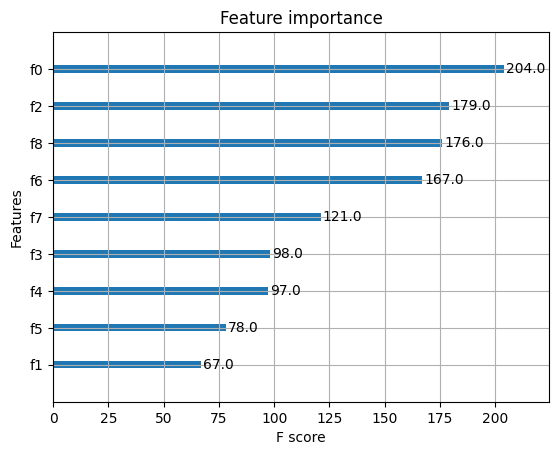

In [110]:
xgb.plot_importance(bst)

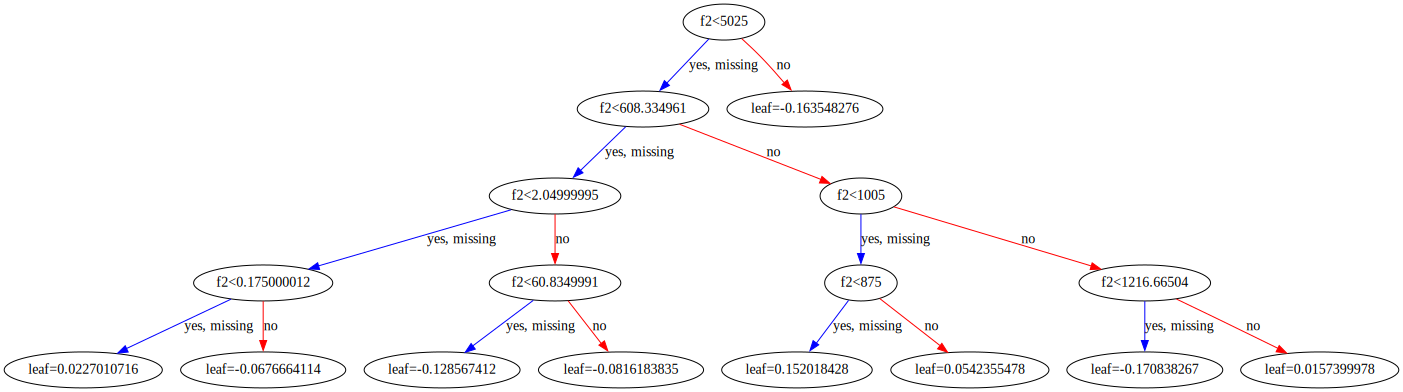

In [111]:
xgb.to_graphviz(bst, num_trees=1)

In [118]:
aux_sample = test_sample
#aux_sample['choice'] = preds
aux_sample['choice'] = pred_binary

C:\Users\zarkwang\AppData\Local\Temp\ipykernel_17340\1650664761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_sample['choice'] = pred_binary


In [120]:
cross_valid.test_model(style=style,test_sample=aux_sample,params=train_result["params"])

{'mse': 0.10449314679205124,
 'mae': 0.3208168468940754,
 'accuracy': 0.9313619684869415,
 'log_like': -1868.5663818506605}